In [1]:
import os, sys
from getpass import getpass
import numpy as np
from math import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

!pip install -qq gpflow

!pip install matplotlib_scalebar
plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-white') 
import matplotlib.ticker as tick
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar

import tensorflow as tf
import tensorflow_probability as tfp
from scipy.ndimage import maximum_filter
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tfb = tfp.bijectors

import gpflow as gpf

print(tfp.__version__)
print(tf.__version__)
plt.style.use('seaborn-whitegrid')
#plt.style.available

0.12.1
2.4.1


## Load the data

In [2]:
inputfile = datadir + '../data/2015/CompletePhotoCount2015.csv'
df =pd.read_csv(inputfile)


In [3]:
len(df)

1583

In [4]:
print(df.expert.sum() )


30992


In [5]:
df.Area.sum()

54.115743327604285

## Preprocess and plot the counts and positions

In [6]:
X = df[['coords.x1.1','coords.x2.1']].values.astype(np.float64)/1000
wdata = df['expert'].values[:,None].astype(np.float64)




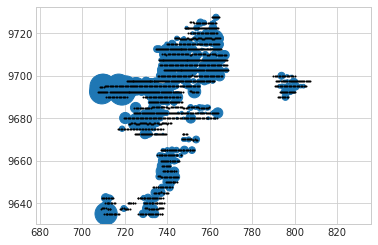

In [7]:

plt.scatter(X[:,0],X[:,1],s=wdata)
plt.scatter(X[:,0],X[:,1],s=1,c='k')

plt.axis('equal')
plt.show()



## Define the survey area by padding around the observations with zero counts

In [8]:

x,y=X[:,0],X[:,1]
offset = 3
gridwidth = 1 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a image is within 5km
H1 = maximum_filter(H, size=3)


# only keep if a image is within 5km
H2 = maximum_filter(H, size=8)


xx = xx[(H1==0)&(H2>0)]
yy = yy[(H1==0)&(H2>0)]
x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid=x_grid.T

x_grid.shape



(1548, 2)

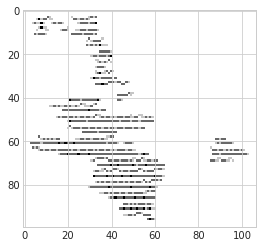

In [9]:
plt.imshow(H)

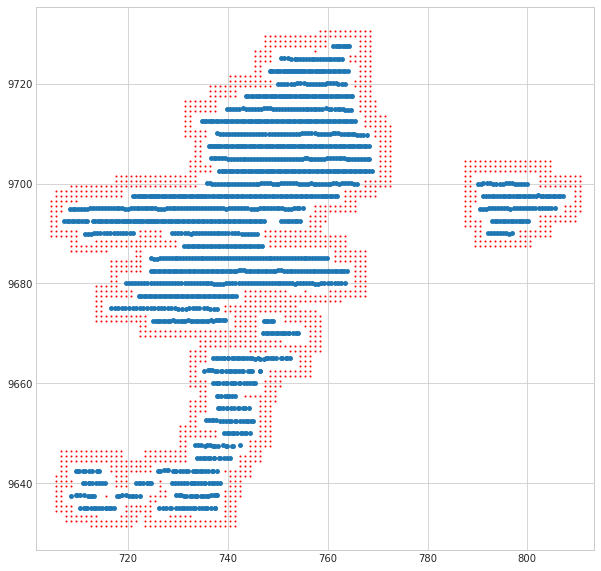

In [10]:
plt.figure(figsize=(10,10))
plt.scatter((x_grid[:,0]),(x_grid[:,1]),s=1,c='r')
#plt.scatter(X[:,0],X[:,1],alpha=0.2)#,s=wdata)
plt.scatter(X[:,0],X[:,1],s=15)

plt.axis('equal')
plt.show()

In [11]:
X.shape

Xc = np.vstack((X,x_grid))
wdata.shape

wdummy = np.zeros((x_grid.shape[0],1))
wdatac = np.vstack((wdata,wdummy))



areasreal = df.Area.values

areadummy = np.ones((x_grid.shape[0]))*areasreal.mean()
areac = np.vstack((areasreal[:,None],areadummy[:,None]))



In [13]:
data = (Xc, wdatac)
areas = areac[:,0]

## Create the likelihood

This is where the Zero-Inflated Poisson likelihood is created. It uses 2 latent fields (f and g) and uses them as inputs to a Mixture model which is a combination of Deterministic zeros and a Poisson distribution (see e.g. here https://github.com/tensorflow/probability/issues/1134)

In [14]:
from gpflow.config import default_float

class ZipLikelihood(gpf.likelihoods.MultiLatentTFPConditional):
    """
    Zero-inflated Poisson Likelihood where the conditional distribution
    is given by a TensorFlow Probability Distribution.
    The `presence` and `rate` of the distribution are given by a
    two-dimensional multi-output GP.
    """

    def __init__(
        self,
         binsize=1.0,
        **kwargs,
    ):
        """
        :param binsize: array of areas for Poisson distribution
        """
        self.binsize = np.reshape(np.array(binsize, dtype=default_float()),(-1,1))

        def conditional_distribution(Fs) -> tfp.distributions.Distribution:
            tf.debugging.assert_equal(tf.shape(Fs)[-1], 2)
            f = (Fs[..., :1])
            g = (Fs[..., 1:])
            
            g = tf.math.sigmoid(g)
            h = tf.stack((1-g,g),axis=-1)
            
            return tfd.Mixture(cat=tfd.Categorical(probs=(h)),
                                      components=[tfd.Deterministic(loc=tf.zeros_like((f))),
                                      tfd.Poisson(log_rate= (f + tf.math.log(self.binsize)))])


        super().__init__(
            latent_dim=2, conditional_distribution=conditional_distribution, **kwargs,
        )


## Create the model

We use default initial conditions for the kernels with initial mean values for the GPs taken from the data.

Priors are uniform but could be added.

In [16]:

# average intensity of images with wildebeest present
mean_log_intensity = np.log(wdata[wdata>0].sum()/areasreal[wdata[:,0]>0].sum())

# average probability of wildebeest present
p = wdatac[wdatac>0].shape[0]/wdatac.shape[0]
mean_presence = np.log(p/(1-p))


num_latent_gps=2

kernel = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.Matern32(),  # This is k1, the kernel of f
        gpf.kernels.Matern32(),  # this is k2, the kernel of g
    ]
)

inducing_variable = gpf.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpf.inducing_variables.InducingPoints(Xc[::1]),  # This is U1 = f1(Z1)
        gpf.inducing_variables.InducingPoints(Xc[::1]),  # This is U2 = f2(Z2)
    ]
)

likelihood = ZipLikelihood(binsize=areas)

means = np.array([mean_log_intensity,mean_presence]).reshape((-1,1))
mean_fn = gpf.mean_functions.Constant(c=means)

svgp = gpf.models.SVGP(inducing_variable=inducing_variable,
                        kernel=kernel,
                        mean_function=mean_fn,
                        num_latent_gps=num_latent_gps,
                        likelihood = likelihood  )



In [17]:
gpf.set_trainable(svgp.inducing_variable, False)
svgp

name,class,transform,prior,trainable,shape,dtype,value
SVGP.mean_function.c,Parameter,Identity,,True,"(2, 1)",float64,[[ 7.01419735] [-1.03778415]]
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,False,"(3131, 2)",float64,"[[710.40315946, 9635.08760942..."
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,False,"(3131, 2)",float64,"[[710.40315946, 9635.08760942..."
SVGP.q_mu,Parameter,Identity,,True,"(3131, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 3131, 3131)",float64,"[[[1., 0., 0...."


## Next we optimize the model

We use ADAM to optimize as it's faster and we can monitor the loss

In [ ]:


lr = 1e-2
adam_opt = tf.optimizers.Adam(lr)

train_steps=5000
report = 2

pbar = tqdm(range(train_steps))
loss_history = np.zeros((train_steps//report))



training_loss = svgp.training_loss_closure(data, compile=True)

@tf.function
def optimization_step():
    adam_opt.minimize(training_loss, var_list=svgp.trainable_variables)

for i in pbar:


    optimization_step()
    

    if i % report == 0:
        elbo = -training_loss().numpy()
        loss_history[i//report] = training_loss().numpy()
    
           
    pbar.set_description("%0.4f" % (elbo))


  0%|          | 0/5000 [00:00<?, ?it/s]

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).
Instructions for updating:
The `use_static_graph` argument is deprecated. Mixture behaves equivalently to `use_static_graph=True`, and the flag is ignored.


-4713.5878:  65%|██████▍   | 3238/5000 [6:01:46<3:20:26,  6.83s/it]

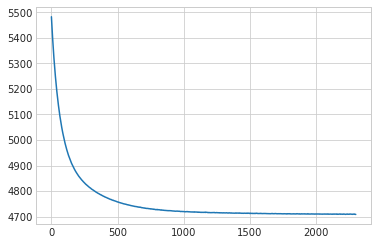

In [20]:
plt.plot(loss_history[200:])
plt.show()

## Print optimised values

In [21]:
gpf.utilities.print_summary(svgp)


╒════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                               │ class     │ transform      │ prior   │ trainable   │ shape           │ dtype   │ value                                                │
╞════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SVGP.mean_function.c                               │ Parameter │ Identity       │         │ True        │ (2, 1)          │ float64 │ [[ 6.0461983 ]                                       │
│                                                    │           │                │         │             │                 │         │  [-4.06872298]]                                      │
├────────────────────────────────────────────

## Make a grid for plotting the fields

(9888, 2)


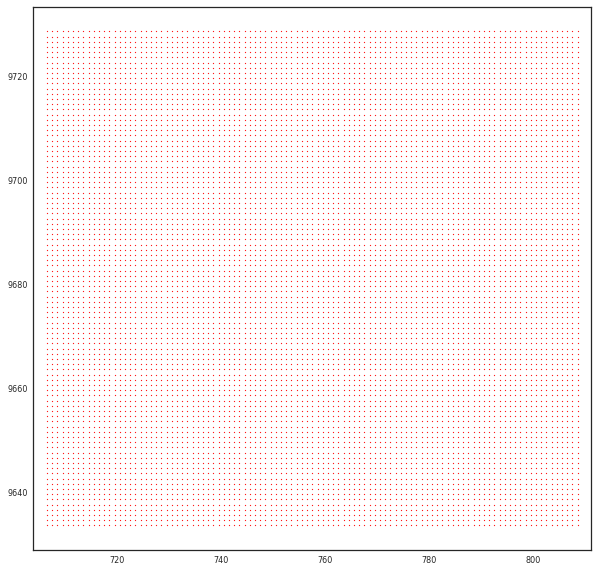

In [42]:
x,y=X[:,0],X[:,1]
offset = 1
gridwidth = 1 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

# flag for only keeping if an image is within 5km
H = maximum_filter(H, size=5)

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid=x_grid.T

print(x_grid.shape)

plt.figure(figsize=(10,10))
plt.scatter((x_grid[:,0]),(x_grid[:,1]),s=1,c='r')
plt.axis('equal')
plt.show()

## Take a sample from the optimised model for plotting the fields

In [43]:


# # predict the 2 latent functions       
y_pred = svgp.predict_f_samples(x_grid).numpy()
f_pred = y_pred[:,0]
g_pred = y_pred[:,1]


g_pred_sig = (tf.nn.sigmoid(g_pred).numpy().reshape(xx.shape))#>0.5
g_pred_sig[H==0]=0

f_pred = (f_pred.reshape(xx.shape))
f_pred_present = f_pred.copy()
f_pred_present[g_pred_sig<0.1]=np.nan


### Also take random samples of the abundance - only within the survey area

(3215, 2)


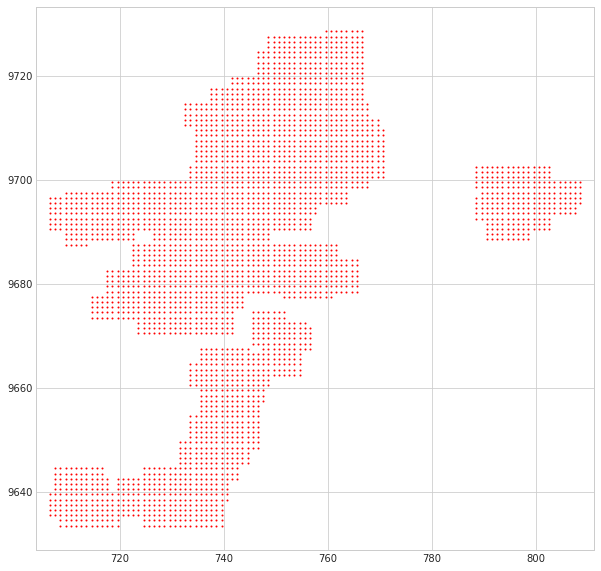

In [26]:
x,y=X[:,0],X[:,1]
offset = 1
gridwidth = 1 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a image is within 5km
H = maximum_filter(H, size=5)


xx = xx[H>0]
yy = yy[H>0]


x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid=x_grid.T

print(x_grid.shape)

plt.figure(figsize=(10,10))
plt.scatter((x_grid[:,0]),(x_grid[:,1]),s=1,c='r')
plt.axis('equal')
plt.show()

In [27]:


nrepeats = 100
nsamp = 1000

totals = []
for _ in tqdm(range(nrepeats)):
    y_pred = svgp.predict_f_samples(x_grid,nsamp).numpy()#+0.5*vgp.predict_f(x_grid)[1].numpy()
    f_pred = y_pred[...,0]
    g_pred = y_pred[...,1]

    presence_probs = tf.nn.sigmoid(g_pred).numpy()

    samples = tfd.Poisson(log_rate=f_pred+np.log(gridwidth*gridwidth)).sample()
    samples = tf.where(tfd.Bernoulli(probs=presence_probs).sample()>0,samples,tf.zeros_like(samples))

    totals.append(tf.reduce_sum(samples,axis=1).numpy())



100%|██████████| 100/100 [07:46<00:00,  4.66s/it]


In [29]:
totals = np.array(totals).flatten()

In [31]:
print(np.percentile(totals,95))
print(np.percentile(totals,5))
print(np.percentile(totals,50))
print(np.mean(totals))

1548680.05
1177577.1500000001
1343905.5
1351044.53211


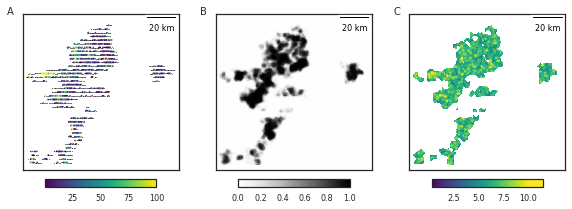

In [151]:
fig, axs = plt.subplots(1, 3, figsize=(8,2.8),sharex=False,sharey=False, constrained_layout=True)


ax00 = axs[0].scatter(X[wdata[:,0]>0,0],X[wdata[:,0]>0,1],c=wdata[wdata[:,0]>0,0],s=2,cmap='viridis',vmax=100)
axs[0].set_aspect('equal')

ax00a = axs[0].scatter(X[wdata[:,0]==0,0],X[wdata[:,0]==0,1],s=1,marker='.',c='k')


cbar = fig.colorbar(ax00, ax=axs[ 0],orientation="horizontal",aspect=5,fraction = 0.5,  shrink=0.6)#,format=formatter)

cbar.ax.tick_params(labelsize=8) 



ax01 = axs[ 1].contourf(xx,yy, g_pred_sig,50,cmap='Greys',vmax=1,zorder=-20)

axs[1].set_rasterization_zorder(-10)
axs[1].set_aspect('equal')
cbar = fig.colorbar(ax01, ax=axs[1],orientation="horizontal",aspect=5,fraction = 0.5,  shrink=0.6)#,format=formatter)

cbar.ax.tick_params(labelsize=8) 
tick_locator = tick.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()



ax10 = axs[2].contourf(xx,yy,f_pred_present,50,cmap='viridis',vmax=10,zorder=-20)

axs[2].set_rasterization_zorder(-10)
axs[2].set_aspect('equal')
cbar = fig.colorbar(ax10, ax=axs[2],orientation="horizontal",aspect=5,fraction = 0.5,  shrink=0.6)#,format=formatter)

cbar.ax.tick_params(labelsize=8) 
tick_locator = tick.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

axs[0].text(-0.1,1,'A', size=10, transform=axs[0].transAxes)
axs[1].text(-0.1,1,'B', size=10, transform=axs[1].transAxes)
axs[2].text(-0.1,1,'C', size=10, transform=axs[2].transAxes)


axs[0].add_artist(ScaleBar(1,"km",font_properties = {"size": 8}))
axs[1].add_artist(ScaleBar(1,"km",font_properties = {"size": 8}))
axs[2].add_artist(ScaleBar(1,"km",font_properties = {"size": 8}))



axs[0].set_xlim(705,810)
axs[0].set_ylim(9630,9735)
axs[1].set_xlim(705,810)
axs[1].set_ylim(9630,9735)
axs[2].set_xlim(705,810)
axs[2].set_ylim(9630,9735)


axs[0].tick_params( labelleft=False, labelbottom=False) 
axs[1].tick_params( labelleft=False, labelbottom=False) 
axs[2].tick_params( labelleft=False, labelbottom=False) 



plt.savefig("2015_results.pdf",bbox_inches='tight')
plt.show()

No handles with labels found to put in legend.


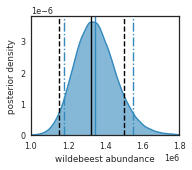

In [164]:
fig, axs = plt.subplots(1, 1, figsize=(2.66,4.8),sharex=False,sharey=False, constrained_layout=False)


sns.kdeplot(totals,ax=axs,alpha=0.6,color='C1',fill=True)
sns.kdeplot(totals,ax=axs,color='C1',fill=False)

axs.set_xlim(1e6,1.8e6)
axs.axvline(1.326e6,c='k')
axs.axvline(1.152e6,c='k',ls='--')
axs.axvline(1.500e6,c='k',ls='--')

axs.axvline(np.percentile(totals,95),c='C1',ls='-.')
axs.axvline(np.percentile(totals,5),c='C1',ls='-.')
axs.axvline(np.percentile(totals,50),c='C1')
axs.legend()
axs.ticklabel_format(axis='x', style='sci',scilimits=(0,3), useOffset=False)
#plt.show()
axs.ticklabel_format(axis='y', style='sci',scilimits=(0,3), useOffset=False)


aspectratio=0.8
ratio_default=(axs.get_xlim()[1]-axs.get_xlim()[0])/(axs.get_ylim()[1]-axs.get_ylim()[0])
axs.set_aspect(ratio_default*aspectratio)
axs.set_xlabel('wildebeest abundance')
axs.set_ylabel('posterior density')


plt.savefig("2015_abundance.pdf",bbox_inches='tight')
plt.show()